In [54]:
import os,sys
import pandas as pd
import collections
import matplotlib
from collections import defaultdict, Counter

import sourmash
from sourmash.lca import lca_utils

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns

figs_path = os.path.abspath(os.path.join('../figs'))
if figs_path not in sys.path:
    sys.path.append(figs_path)
    
from sourmash_sankey import GenomeSankeyFlow

In [2]:
pd.__version__

'1.1.3'

In [3]:
from IPython.display import display, Markdown

In [4]:
pathInfo = pd.read_csv("../gtdb95-evolpaths.csv.gz")
pathInfo

,accession,path,rank,lineage
0,GCA_003661365.1,path1,superkingdom,d__Archaea;p__Thermoproteota;c__Korarchaeia;o_...
1,GCA_003661365.1,path2,superkingdom,d__Archaea;p__Thermoproteota;c__Korarchaeia;o_...
2,GCA_003661365.1,path3,superkingdom,d__Archaea;p__Thermoproteota;c__Korarchaeia;o_...
3,GCA_003661365.1,path4,superkingdom,d__Archaea;p__Thermoproteota;c__Korarchaeia;o_...
4,GCA_003661365.1,path5,superkingdom,d__Archaea;p__Thermoproteota;c__Korarchaeia;o_...
...,...,...,...,...
20694,GCA_002774315.1,path2957,phylum,d__Bacteria;p__WOR-3;c__UBA3073;o__UBA3073;f__...
20695,GCA_003645615.1,path2957,order,d__Bacteria;p__WOR-3;c__WOR-3;o__SM23-42;f__B3...
20696,GCA_001303785.1,path2957,family,d__Bacteria;p__WOR-3;c__WOR-3;o__SM23-42;f__SM...
20697,GCA_001303225.1,path2957,genus,d__Bacteria;p__WOR-3;c__WOR-3;o__SM23-42;f__SM...


In [5]:
genome_info = pathInfo.drop(columns=["path", "rank"])
genome_info.drop_duplicates(inplace=True)
genome_info 

,accession,lineage
0,GCA_003661365.1,d__Archaea;p__Thermoproteota;c__Korarchaeia;o_...
52,GCA_001940645.1,d__Archaea;p__Asgardarchaeota;c__Heimdallarcha...
54,GCA_005191425.1,d__Archaea;p__Asgardarchaeota;c__Lokiarchaeia;...
56,GCA_004524545.1,d__Archaea;p__Asgardarchaeota;c__Lokiarchaeia;...
58,GCA_004375715.1,d__Archaea;p__Asgardarchaeota;c__Lokiarchaeia;...
...,...,...
20694,GCA_002774315.1,d__Bacteria;p__WOR-3;c__UBA3073;o__UBA3073;f__...
20695,GCA_003645615.1,d__Bacteria;p__WOR-3;c__WOR-3;o__SM23-42;f__B3...
20696,GCA_001303785.1,d__Bacteria;p__WOR-3;c__WOR-3;o__SM23-42;f__SM...
20697,GCA_001303225.1,d__Bacteria;p__WOR-3;c__WOR-3;o__SM23-42;f__SM...


In [6]:
def make_lineages(row):
    row["lineage"] = lca_utils.make_lineage(row["lineage"])
    return row

In [13]:
genome_info = genome_info.apply(make_lineages, axis=1)
genome_info

,accession,lineage
0,GCA_003661365.1,"((superkingdom, d__Archaea), (phylum, p__Therm..."
52,GCA_001940645.1,"((superkingdom, d__Archaea), (phylum, p__Asgar..."
54,GCA_005191425.1,"((superkingdom, d__Archaea), (phylum, p__Asgar..."
56,GCA_004524545.1,"((superkingdom, d__Archaea), (phylum, p__Asgar..."
58,GCA_004375715.1,"((superkingdom, d__Archaea), (phylum, p__Asgar..."
...,...,...
20694,GCA_002774315.1,"((superkingdom, d__Bacteria), (phylum, p__WOR-..."
20695,GCA_003645615.1,"((superkingdom, d__Bacteria), (phylum, p__WOR-..."
20696,GCA_001303785.1,"((superkingdom, d__Bacteria), (phylum, p__WOR-..."
20697,GCA_001303225.1,"((superkingdom, d__Bacteria), (phylum, p__WOR-..."


In [14]:
lineageD = pd.Series(genome_info.lineage.values,index=genome_info.accession).to_dict()

In [15]:
all_lineages = list(lineageD.values())

In [16]:
all_lineages[0]

(LineagePair(rank='superkingdom', name='d__Archaea'),
 LineagePair(rank='phylum', name='p__Thermoproteota'),
 LineagePair(rank='class', name='c__Korarchaeia'),
 LineagePair(rank='order', name='o__Korarchaeales'),
 LineagePair(rank='family', name='f__QMVU01'),
 LineagePair(rank='genus', name='g__QMVU01'),
 LineagePair(rank='species', name='s__QMVU01 sp003661365'))

## Try making sunburst plots

In [44]:
def get_parent_and_names(row):
    lineage = row["lineage"]
    if lineage[-1][0] == "superkingdom":
        row["parent"] = None
    else:
        row["parent"] = lineage[:-1]
        row["parent_name"] = lineage[:-1][-1][1][3:]
    row["name"] = lineage[-1][1][3:]
    row["superkingdom"] = lineage[0][1][3:]
#    row["color"] = obj.colors[lineage]

  # row[]
    return row


def build_hierarchical_lineage_dataframe(lineages, stop_rank="genus"):
    """
    Build a hierarchy of levels for Sunburst or Treemap charts.

    Levels are given starting from the bottom to the top of the hierarchy,
    ie the last level corresponds to the root.
    """
    taxlist = list(lca_utils.taxlist(include_strain=False))
    stop_index = taxlist.index(stop_rank)
    print(stop_index)
    truncated_taxlist = taxlist[:stop_index+1]
    print(truncated_taxlist)
    lineageCounts = defaultdict(int)
    # get hierachical counts!
    for lin in lineages:
        for rank in truncated_taxlist:
            ranklin = lca_utils.pop_to_rank(lin, rank)
            lineageCounts[ranklin]+=1
    
    # now make dataframe
    hDF = pd.DataFrame.from_dict(lineageCounts, orient='index', columns=['counts']).reset_index()
    hDF.rename(columns={"index": "lineage"}, inplace=True)
    hDF=hDF.apply(get_parent_and_names, axis=1)
    return hDF


    #print(hDF.head())
df= build_hierarchical_lineage_dataframe(all_lineages, stop_rank="phylum")
df.tail()

1
['superkingdom', 'phylum']


,counts,lineage,name,parent,parent_name,superkingdom
30,287,"((superkingdom, d__Bacteria), (phylum, p__Pate...",Patescibacteria,"((superkingdom, d__Bacteria),)",Bacteria,Bacteria
31,150,"((superkingdom, d__Bacteria), (phylum, p__Plan...",Planctomycetota,"((superkingdom, d__Bacteria),)",Bacteria,Bacteria
32,76,"((superkingdom, d__Bacteria), (phylum, p__Spir...",Spirochaetota,"((superkingdom, d__Bacteria),)",Bacteria,Bacteria
33,152,"((superkingdom, d__Bacteria), (phylum, p__Verr...",Verrucomicrobiota,"((superkingdom, d__Bacteria),)",Bacteria,Bacteria
34,11,"((superkingdom, d__Bacteria), (phylum, p__WOR-3))",WOR-3,"((superkingdom, d__Bacteria),)",Bacteria,Bacteria


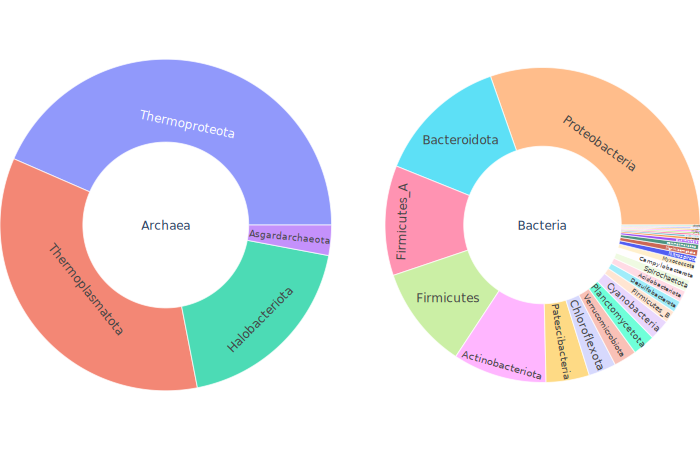

In [45]:
fig = make_subplots(1, 2, specs=[[{"type": "domain"}, {"type": "domain"}]],)

#obj.colors[lin]

#fig = go.Figure()
archaea_df=df[df["superkingdom"] =="Archaea"]
bacteria_df=df[df["superkingdom"] =="Bacteria"]

fig.add_trace(go.Sunburst(
    labels=archaea_df['name'],
    parents=archaea_df['parent_name'],
    values=archaea_df['counts'],
    branchvalues='total',
    domain=dict(column=0),
    #marker=dict(
    #    colors=df_all_trees['color'],
    #    colorscale='RdBu',
    #    cmid=average_score),
    #hovertemplate='<b>%{label} </b> <br> Sales: %{value}<br> Success rate: %{color:.2f}',
    #name='Archaea',
    ))
fig.add_trace(go.Sunburst(
    labels=bacteria_df['name'],
    parents=bacteria_df['parent_name'],
    values=bacteria_df['counts'],
    branchvalues='total',
    domain=dict(column=1),
    #insidetextorientation='radial',
    maxdepth=2,
    #marker=dict(
    #    colors=df_all_trees['color'],
    #    colorscale='RdBu',
    #    cmid=average_score),
    #hovertemplate='<b>%{label} </b> <br> Sales: %{value}<br> Success rate: %{color:.2f}',
    #name='Bacteria'
    ), 1, 2)

fig.update_layout(
    grid= dict(columns=2, rows=1),
    margin = dict(t=0, l=0, r=0, b=0)
)

fig.show("svg")
#fig.write_html('gtdb95-evolpaths-taxonomysunburst.phylum.html', auto_open=True)


In [50]:
def color_by_rank(obj, counts, color_rank="phylum", color_lineage_subset=None, alt_palette_map=None, returnDF=False):
    "select colors based on taxonomy at given color rank"
    palette_map={"d__Bacteria": "crest",  "d__Archaea": "flare", "d__Eukaryota": "viridis"}
    if alt_palette_map:
        palette_map.update(alt_palette_map)
    full_lins = list(counts.keys())
    
    color_lins = defaultdict(list)
    # first pass: count items to color (by superk)
    for lin in full_lins:
        superk = lca_utils.pop_to_rank(lin, "superkingdom")[0].name
        #color_lins[superk]+=1
        color_lins[superk].append(lca_utils.pop_to_rank(lin, color_rank))
    
    # now generate color lists for each superkingdom
    colors_to_use=defaultdict()
    for superk in color_lins.keys():
        if superk not in palette_map.keys():
            print(f"yikes, unknown superkingdom! Please provide an 'alt_palette_map' dictionary mapping superkingdom {superk} to a continuous color brewer palette (e.g. crest, flare, etc)")
        else:
            #for superk, clins in color_lins.items():
            clins = color_lins[superk]
            palette = palette_map[superk]
            these_colors = sns.color_palette(palette, n_colors=len(set(clins))).as_hex()
            color_map = {}
            for cl in clins:
                # set colors sequentially, only using new ones when we have a new key
                if cl not in color_map.keys():
                    color_map[cl] = these_colors.pop()
            colors_to_use[superk] = color_map
                # assign colors
                
    # second pass: assign colors
    color_this_lin=True
    for lin in full_lins:
        superk = lca_utils.pop_to_rank(lin, "superkingdom")[0].name
        ## enable selective coloration
        if color_lineage_subset:
            color_this_lin=False
            for subset_lin in color_lineage_subset:
                if lca_utils.is_lineage_match(subset_lin, lin, subset_lin[-1].rank):
                    color_this_lin=True
                    break
        if color_this_lin:
            color_lin = lca_utils.pop_to_rank(lin, color_rank)
            obj.colors[lin] = colors_to_use[superk][color_lin]

In [51]:
def make_sunburst_fig(obj, title):
    "Build a plotly figure/sankey diagram."
    # make the data to go into the sankey figure.
    labels = obj.make_labels()
    src_l, dest_l, cnt_l, color_l, label_l = obj.make_lists()
    
    fig.add_trace(go.Sunburst(
        ids=dest_l[:20],
        labels=label_l[:20],
        parents=src_l[:20],
        values=cnt_l[:20],
        #domain=dict(column=1),
        maxdepth=2,
        insidetextorientation='radial'
     ))
    if title:
        fig.update_layout(title_text=title, font_size=10)

    return fig

In [52]:
def lineages_to_sunburst(title, lineages, stop_rank="genus", color_rank="phylum", color_lineage_subset=None):
    obj = GenomeSankeyFlow(stop_rank=stop_rank, count_item="genomes")
    counts = collections.Counter()
    num_bact=0
    num_arch=0
    for lin in lineages:
        gl = lca_utils.pop_to_rank(lin, stop_rank)
        counts[gl] +=1
    color_by_rank(obj, counts, color_rank, color_lineage_subset=color_lineage_subset)
    obj.make_links(counts)
    fig = make_sunburst_fig(obj, title)
    return fig

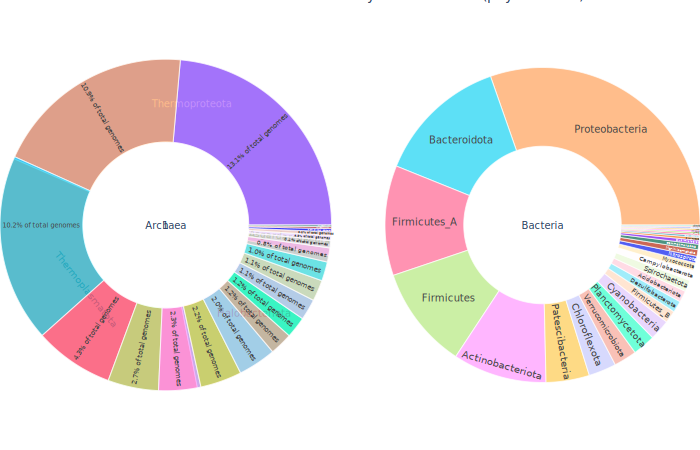

In [55]:
title = "Taxonomic Distribution: GTDB r95 'Evolutionary Paths' dataset (phylum-level)"
fig = lineages_to_sunburst(title, all_lineages, stop_rank="phylum")
#fig.write_html('gtdb95-evolpaths-taxonomysankey.phylum.html', auto_open=True)
fig.show("svg")

In [ ]:
stop_rank="phylum"
lineages=all_lineages
color_rank="phylum"
color_lineage_subset=None
obj = GenomeSankeyFlow(stop_rank=stop_rank, count_item="genomes")
counts = collections.Counter()
num_bact=0
num_arch=0
for lin in all_lineages:
    gl = lca_utils.pop_to_rank(lin, stop_rank)
    counts[gl] +=1
color_by_rank(obj, counts, color_rank, color_lineage_subset=color_lineage_subset)
obj.make_links(counts)
labels = obj.make_labels()
src_l, dest_l, cnt_l, color_l, label_l = obj.make_lists()
total_counts = obj.sum_counts
print(total_counts)


In [ ]:
print(len(dest_l))
fig =go.Figure(go.Sunburst(
    labels=dest_l[:29],
    parents=src_l[:29],
    values=cnt_l[:29],
))
fig.show()
#fig.write_html('test-sunburst.html', auto_open=True)


In [ ]:
#make dataframe to use express?
linkDF = pd.DataFrame(
    {'source': src_l,
     'dest': dest_l,
     'count': cnt_l,
     'color': color_l,
     'label': label_l
    })
linkDF.head()

In [58]:
def split_lineages_to_columns(row):
    #rank_d = {"d__": "superkingdom", "p__": "phylum", "c__": "class", "o__": "order", "f__": "family", "g__": "genus", "s__": "species"}
    # split taxonomy column on ";"
    lineages = row["lineage"].split(";")
    row["superkingdom"] = lineages[0].split("d__")[1]
    row["phylum"] = lineages[1].split("p__")[1]
    row["class"] = lineages[2].split("c__")[1]
    row["order"] = lineages[3].split("o__")[1]
    row["family"] = lineages[4].split("f__")[1]
    row["genus"] = lineages[5].split("g__")[1]
    row["species"] = lineages[6].split("s__")[1]
    row["strain"] = ""
    return row


In [60]:
pathInfo = pathInfo.apply(split_lineages_to_columns, axis=1)

In [61]:
gDF = pathInfo.drop(columns = ["lineage", "strain"])

In [62]:
gDF["count"] = 1

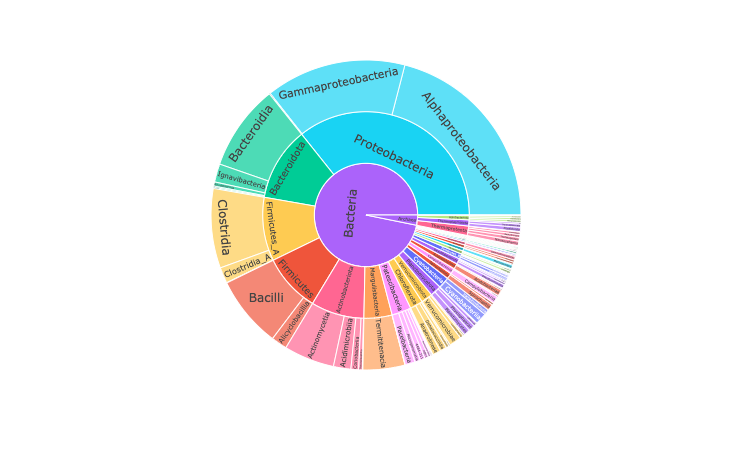

In [63]:
fig = px.sunburst(gDF, path=['superkingdom', 'phylum', 'class'], values='count',
                  color='phylum',# hover_data=['iso_alpha'],
                  color_continuous_scale='RdBu',
                  color_continuous_midpoint=gDF['count']/6690)
                  #color_continuous_midpoint=np.average(df['lifeExp'], weights=df['pop']))

fig.show()
#df.head()

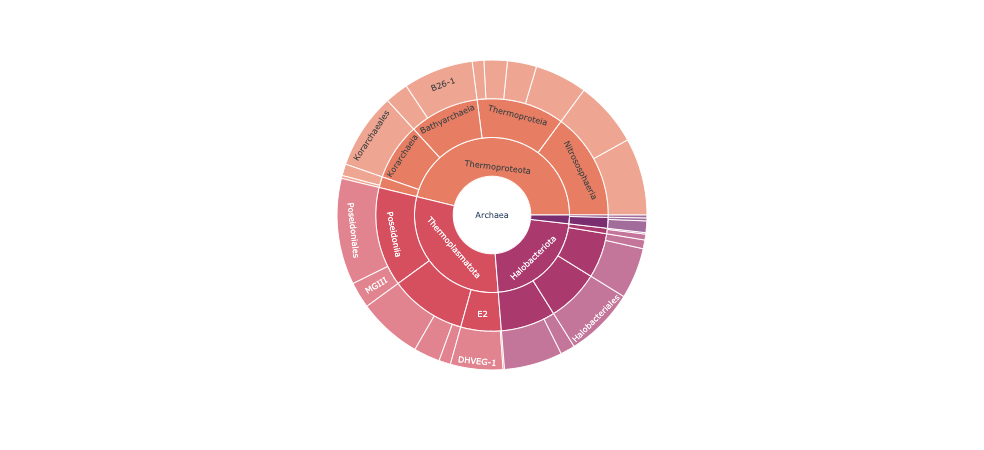

In [110]:
arch_df = gDF[gDF["superkingdom"] == "Archaea"]

fig = px.sunburst(arch_df, path=['superkingdom', 'phylum', 'class', 'order'], values='count',
                  #color='phylum',# hover_data=['iso_alpha'],
                  color_discrete_sequence=sns.color_palette("flare", arch_df.phylum.nunique()).as_hex(),
                  )
                  #color_continuous_scale='RdBu',
                  #color_continuous_midpoint=gDF['count']/6690)
                  #color_continuous_midpoint=np.average(df['lifeExp'], weights=df['pop']))
fig.update_layout(uniformtext=dict(minsize=8, mode='hide'))
fig.show()
#df.head()

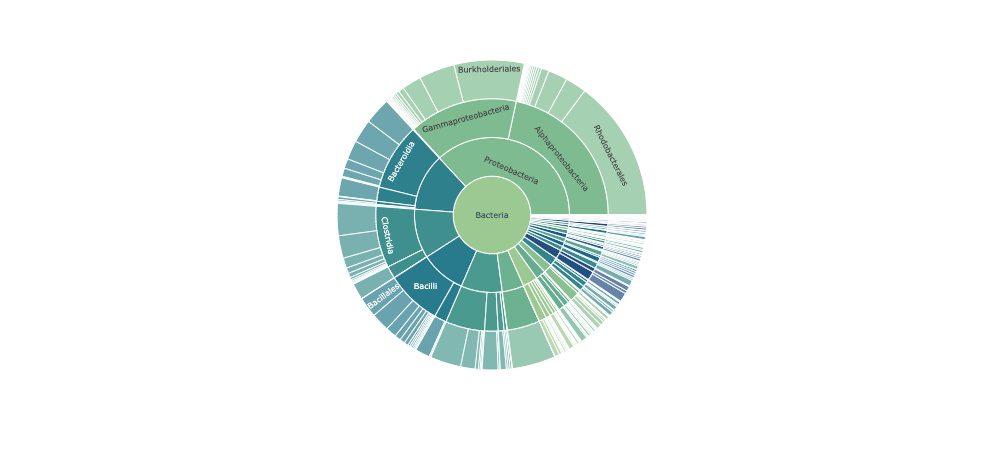

In [112]:
bact_df = gDF[gDF["superkingdom"] == "Bacteria"]

fig = px.sunburst(bact_df, path=['superkingdom', 'phylum', 'class', "order"], values='count',
                  color="phylum",# hover_data=['iso_alpha'],
                  color_discrete_sequence=sns.color_palette("crest", bact_df.phylum.nunique()).as_hex(),
                  )
                  #color_discrete_sequence=px.colors.qualitative.Antique,)
                  #px.colors.sequential
                  #color_continuous_scale='RdBu',
                  #color_continuous_midpoint=gDF['count']/6690)
                  #color_continuous_midpoint=np.average(df['lifeExp'], weights=df['pop']))
fig.update_layout(uniformtext=dict(minsize=8, mode='hide'))
fig.show()
#df.head()

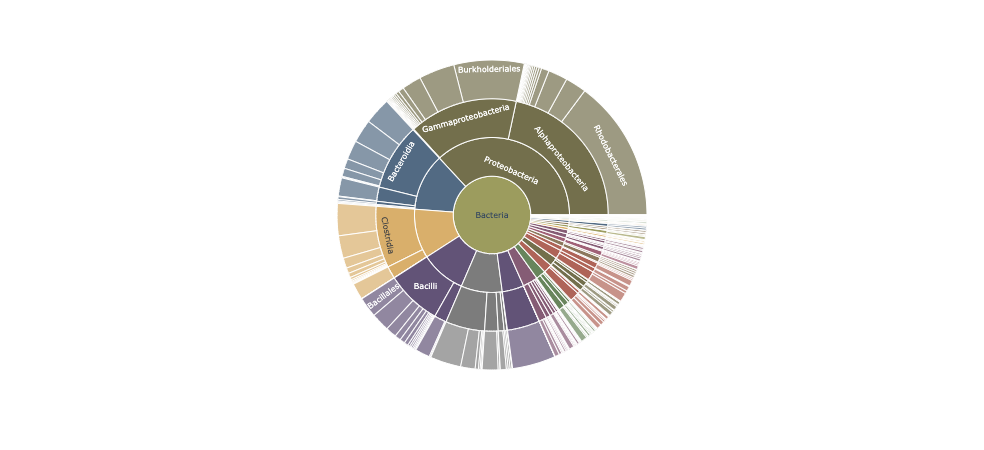

In [111]:
bact_df = gDF[gDF["superkingdom"] == "Bacteria"]

fig = px.sunburst(bact_df, path=['superkingdom', 'phylum', 'class', "order"], values='count',
                  color="phylum",# hover_data=['iso_alpha'],
                  #color_discrete_sequence=sns.color_palette("crest_r", bact_df.phylum.nunique()).as_hex(),
                  color_discrete_sequence=px.colors.qualitative.Antique,)
                  #px.colors.sequential
                  #color_continuous_scale='RdBu',
                  #color_continuous_midpoint=gDF['count']/6690)
                  #color_continuous_midpoint=np.average(df['lifeExp'], weights=df['pop']))
fig.update_layout(uniformtext=dict(minsize=8, mode='hide'))
fig.show()
#df.head()

In [86]:
bact_df

,accession,path,rank,superkingdom,phylum,class,order,family,genus,species,count
658,GCF_004358185.1,path95,superkingdom,Bacteria,Proteobacteria,Alphaproteobacteria,Rhodobacterales,Rhodobacteraceae,Pseudodonghicola,Pseudodonghicola sp004358185,1
659,GCF_004358185.1,path96,superkingdom,Bacteria,Proteobacteria,Alphaproteobacteria,Rhodobacterales,Rhodobacteraceae,Pseudodonghicola,Pseudodonghicola sp004358185,1
660,GCF_004358185.1,path97,superkingdom,Bacteria,Proteobacteria,Alphaproteobacteria,Rhodobacterales,Rhodobacteraceae,Pseudodonghicola,Pseudodonghicola sp004358185,1
661,GCF_004358185.1,path98,superkingdom,Bacteria,Proteobacteria,Alphaproteobacteria,Rhodobacterales,Rhodobacteraceae,Pseudodonghicola,Pseudodonghicola sp004358185,1
662,GCF_004358185.1,path99,superkingdom,Bacteria,Proteobacteria,Alphaproteobacteria,Rhodobacterales,Rhodobacteraceae,Pseudodonghicola,Pseudodonghicola sp004358185,1
...,...,...,...,...,...,...,...,...,...,...,...
20694,GCA_002774315.1,path2957,phylum,Bacteria,WOR-3,UBA3073,UBA3073,UBA3073,UBA3073,UBA3073 sp002774315,1
20695,GCA_003645615.1,path2957,order,Bacteria,WOR-3,WOR-3,SM23-42,B36-G15,B36-G15,B36-G15 sp003645615,1
20696,GCA_001303785.1,path2957,family,Bacteria,WOR-3,WOR-3,SM23-42,SM23-42,SM23-42,SM23-42 sp001303785,1
20697,GCA_001303225.1,path2957,genus,Bacteria,WOR-3,WOR-3,SM23-42,SM23-42,DG-78,DG-78 sp001303225,1
